<a href="https://colab.research.google.com/github/DiploDatos/AnalisisYCuracion/blob/master/07_Encodings_y_PCA_en_Melbourne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Exploración y Curación de Datos**

*Edición 2021*

----

# Encodings

En esta notebook, vamos a cargar el conjunto de datos de [la compentencia Kaggle](https://www.kaggle.com/dansbecker/melbourne-housing-snapshot) sobre estimación de precios de ventas de propiedades en Melbourne, Australia.

Utilizaremos el conjunto de datos reducido producido por [DanB](https://www.kaggle.com/dansbecker). Hemos subido una copia a un servidor de la Universidad Nacional de Córdoba para facilitar su acceso remoto.

In [ ]:
import matplotlib.pyplot as plt
import numpy
import pandas

import seaborn
seaborn.set_context('talk')

In [ ]:
import plotly
plotly.__version__
# Make sure it's 4.14.3

'4.4.1'

In [ ]:
# To update plotly, uncomment and run the following line:
# !pip install plotly --upgrade

In [ ]:
melb_df = pandas.read_csv(
    'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/melb_data.csv')
melb_df[:3]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0


## Codificando valores no numéricos

Hasta este momento hemos realizado análisis de datos sobre distintos tipos de variables aleatorias. Sin embargo, muchos métodos utilizados para *Aprendizaje Automático* pueden ser aplicados solamente a matrices numéricas.

Por ello, antes de comenzar con cualquier tipo de modelado, tenemos que **codificar** (encode) toda la información categórica utilizando unicamente información numérica. Al realizar este proceso tenemos que tener en cuenta algunas propiedades que tendrán nuestros datos codificados, y cómo impactarán en los modelos.

### One-hot encodings

La forma más simple de realizar esta codificación de valores categóricos es construir un vector One-Hot encoding. Opera de la siguiente manera:

1. Se identifica el conjunto $C$ de categorías posibles de la variable aleatoria y la cantida de categorías $N = |C|$
2. Se asigna un número entero a cada categoría en el rango $[0; N)$.
3. Para cada valor $r_i$ de nuestro conjunto de datos con categoría $c_j$:

  1. Se construye un vector $x_i$ de 0s de tamaño $N$.
  2. Se asigna el valor 1 al vector $x_i$ en la posición de la categoría $c_j$.

Comenzaremos a trabajar con la librería scikit-learn, que dispone de la mayoría de funciones necesarias para pre-procesar un conjunto de datos y cuenta con tutoriales que explican las distintas opciones. Les recomendamos la sección de [Encoding Categorical Features](https://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features).

Utilizaremos la clase *OneHotEncoder* para realizar la codificación. Todos los transformadores de scikit-learn siguen una misma interfaz en dos etapas: `fit` y `transform`.
* El método `fit` (entrenar) es el encargado de recopilar toda la información necesaria para aplicar el encoding. En este caso, implementa los pasos 1 y 2 del algoritmo anterior. 
* El método `transform` es el que efectivamente construye los encoding para cada fila del conjunto de datos.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
encoder.fit(melb_df[['Type']])
# We can inspect the categories found by the encoder
encoder.categories_

[array(['h', 't', 'u'], dtype=object)]

In [ ]:
encoded_types = encoder.transform(melb_df[['Type']])
encoded_types[:10]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

Esta transformación es tan común que Scikit-lean implementa el transformador `DictVectorizer` que codifican automáticamente todos las columnas categóricas y los combinan con los datos numéricos existentes.

Para poder utilizarlo, tendremos que convertir el conjunto de datos en una lista de diccionarios.


In [ ]:
feature_cols = ['Suburb', 'Type', 'Distance', 'Bedroom2', 'Bathroom',
            'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Regionname']
feature_dict = list(melb_df[feature_cols].T.to_dict().values())
feature_dict[:2]

[{'Bathroom': 1.0,
  'Bedroom2': 2.0,
  'BuildingArea': nan,
  'Car': 1.0,
  'Distance': 2.5,
  'Landsize': 202.0,
  'Regionname': 'Northern Metropolitan',
  'Suburb': 'Abbotsford',
  'Type': 'h',
  'YearBuilt': nan},
 {'Bathroom': 1.0,
  'Bedroom2': 2.0,
  'BuildingArea': 79.0,
  'Car': 0.0,
  'Distance': 2.5,
  'Landsize': 156.0,
  'Regionname': 'Northern Metropolitan',
  'Suburb': 'Abbotsford',
  'Type': 'h',
  'YearBuilt': 1900.0}]

In [ ]:
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer()
feature_matrix = vec.fit_transform(feature_dict)

In [ ]:
feature_matrix

<13580x332 sparse matrix of type '<class 'numpy.float64'>'
	with 135800 stored elements in Compressed Sparse Row format>

In [ ]:
vec.get_feature_names()[:10]

['Bathroom',
 'Bedroom2',
 'BuildingArea',
 'Car',
 'Distance',
 'Landsize',
 'Regionname=Eastern Metropolitan',
 'Regionname=Eastern Victoria',
 'Regionname=Northern Metropolitan',
 'Regionname=Northern Victoria']

## Matrices esparsas

Las codificaciones one-hot tienen la propiedad de aumentar la cantidad de memoria requerida para almacenar una variable de manera **cuadrática** con respecto al número de categorías. Sin embargo, la mayoría de los elementos de la nueva representación serán nulos. La cantidad de elementos no-nulos de la matriz crece **linealmente** con respecto al número de categorías a representar.

Por ello existen las *matrices esparsas*, que almacenan unicamente los valores no-nulos de una matriz en distintas estructuras de datos.

Los métodos de codificación como `DictVectorizer` o `OneHotEncoding` suelen devolver como resultado matrices esparsas si es más eficiente en términos de recursos computacionales.

![picture](https://matteding.github.io/images/coo.gif)

Existen [distintos tipos de matrices esparsas](https://docs.scipy.org/doc/scipy/reference/sparse.html) y las operaciones sobre cada una de ellas son distintas; y distintas a las matrices densas.

In [ ]:
# Fill nan values on sparse matrix.
if numpy.any(numpy.isnan(feature_matrix.data)):
  feature_matrix.data = numpy.nan_to_num(feature_matrix.data)

Para aplicar algunas transformaciones o modelos es necesario convertir las matrices esparsas a densas. Antes de realizar este cambio, es recomendable calcular el tamaño de la matriz final. Recordar que cada número de punto flotante ocupa 4 bytes para la precisión simple (numpy.float32) y 8 bytes para la precisión doble (numpy.float64).

In [ ]:
# Before doing this type of conversion, it's mandatory to calculate the
# size of the resulting matrix!
matrix_size_mb = feature_matrix.shape[0] * feature_matrix.shape[1] * 4 / 1024 / 1024
print("The dense matrix will weight approximately {:.2f} MB".format(matrix_size_mb))

limit_size_mb = 10
precision_type = numpy.float32
if matrix_size_mb < limit_size_mb:  # Matrix is less than 10MB
  dense_feature_matrix = feature_matrix.astype(precision_type).todense()
else:
  # We calculate how many rows would fit given the number of columns
  n_rows = int(limit_size_mb *1024 * 1024 / 4 / feature_matrix.shape[1])
  print("Matrix too big! Using only first {} of {} rows".format(
      n_rows, feature_matrix.shape[0]))
  dense_feature_matrix = feature_matrix[:n_rows].astype(precision_type).todense()

print("Final size: {:.2f}".format(dense_feature_matrix.nbytes / 1024 / 1024))

The dense matrix will weight approximately 17.20 MB
Matrix too big! Using only first 7895 of 13580 rows
Final size: 10.00


In [ ]:
# Remember to cut your original data as well.
if dense_feature_matrix.shape[0] < len(melb_df):
  melb_df_sample = melb_df.iloc[:dense_feature_matrix.shape[0]]
else:
  melb_df_sample = melb_df

## Reducción de dimensionalidad con PCA

En las siguientes filas, aplicaremos [PCA](https://scikit-learn.org/stable/modules/decomposition.html#pca) para reducir la dimensionalidad del conjunto de datos a 2 dimensiones. Se seguirá un proceso similar al visto en la notebook 06.

In [ ]:
# TODO Here we have to pre-process the matrix before applying PCA
scaled_dense_feature_matrix = dense_feature_matrix

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=15)
pca.fit(scaled_dense_feature_matrix)
proyected_features = pca.transform(scaled_dense_feature_matrix)
proyected_features.shape

(7895, 15)

In [ ]:
pca.explained_variance_ratio_

array([6.3792509e-01, 3.5607338e-01, 5.9889848e-03, 5.1342763e-06,
       4.9828191e-07, 2.2343808e-07, 1.6711644e-07, 1.0355925e-07,
       9.6321827e-08, 7.8661756e-08, 4.3444764e-08, 3.6519740e-08,
       1.0555388e-08, 9.4857224e-09, 8.8374588e-09], dtype=float32)

In [ ]:
melb_df_sample[['pca1_scaled', 'pca2_scaled']] = proyected_features[:,:2]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:659: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [ ]:
g = seaborn.FacetGrid(tips, col="time")
g.map(seaborn.scatterplot, "tip")

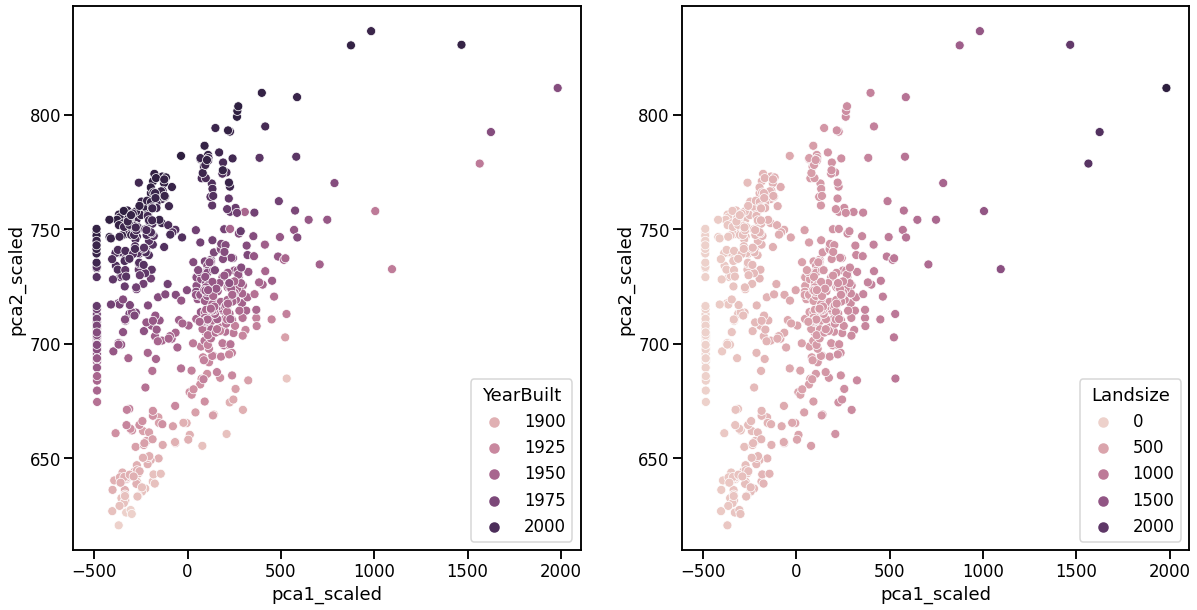

In [ ]:
cols = ['YearBuilt', 'Landsize']
data = melb_df_sample[cols + ['pca1_scaled', 'pca2_scaled']][:1000].dropna(how='any')
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
# Other variables to try: 'Price' 'Landsize' 'Price' 'YearBuilt'
seaborn.scatterplot(data=data, x='pca1_scaled', y='pca2_scaled',
                    hue='YearBuilt', ax=axes[0])  
seaborn.scatterplot(data=data, x='pca1_scaled', y='pca2_scaled',
                    hue='Landsize', ax=axes[1]) 

### Análisis de correlación (visual) con otras variables

Los datos proyectados con métodos como PCA dejan de ser directamente interpertables: cada columna no se corresponde con una propiedad de los datos, sino que es una **combinación** de las propiedades anteriores. 

Sin embargo, a través de las visualizaciones podemos entender qué tanto peso tiene cada una de las variables originales en nuestra nueva transformación. En el gráfico anterior podemos ver que una de las direcciones se corresponde con el año de construcción y la otra con la cantidad de metros construidos. 

**¿Por qué sucede esto?** Porque las variables no están en las mismas unidades. como los valores de los años son muy grandes, esa columna tiene la mayor **varianza** en los datos, y por lo tanto los primeros componentes principales están muy alineados con esa dimensión. 

Tenemos que volver a escalar todos los datos a un mismo rango. ¿Utilizamos estandarización o escalado linear?

### ¿Cuántos componentes principales utilizar?

Cuando queremos visualizar un conjunto de datos con demasiadas dimensiones, proyectamos los puntos a 2D o 3D. Sin embargo, si el objetivo es generar una matriz más pequeña

Text(0.5, 0, 'Components')

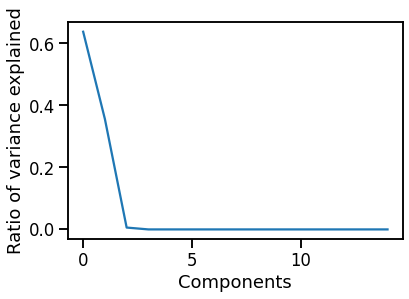

In [ ]:
seaborn.lineplot(x=range(pca.n_components),
                 y=pca.explained_variance_ratio_)
plt.ylabel("Ratio of variance explained")
plt.xlabel("Components")